## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2020.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 100
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
        self.b2 = tf.Variable(np.zeros((10,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,10))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 10
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.2630000114440918
epoch 2: valid acc = 0.29100000858306885
epoch 3: valid acc = 0.3050000071525574
epoch 4: valid acc = 0.3230000138282776
epoch 5: valid acc = 0.3529999852180481
epoch 6: valid acc = 0.39500001072883606
epoch 7: valid acc = 0.41200000047683716
epoch 8: valid acc = 0.44200000166893005
epoch 9: valid acc = 0.4399999976158142
epoch 10: valid acc = 0.4490000009536743
test acc = 0.4498000144958496


### Create Deeper Network

<p style='color:red'><strong>TODO:</strong></p> 

Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias) and consider to use a loop to create your MLP network. Hint: Copy above code and make necessary changes in model definition

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

In [4]:
hidden_dim = 100
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(3072, 1024).astype('float32'))
        self.b1 = tf.Variable(np.zeros((1024,)).astype('float32'))
        
        
        self.W2 = tf.Variable(1e-2*np.random.rand(1024, hidden_dim).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
        self.b3 = tf.Variable(np.zeros((10,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        out = tf.matmul(h2, self.W3) + self.b3
        return out
    
# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,10))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 10
model = Model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.10100000351667404
epoch 2: valid acc = 0.1379999965429306
epoch 3: valid acc = 0.16300000250339508
epoch 4: valid acc = 0.2070000022649765
epoch 5: valid acc = 0.2680000066757202
epoch 6: valid acc = 0.3440000116825104
epoch 7: valid acc = 0.38999998569488525
epoch 8: valid acc = 0.3959999978542328
epoch 9: valid acc = 0.421999990940094
epoch 10: valid acc = 0.4129999876022339
test acc = 0.43149998784065247


## Part 2: t-SNE (optional, bonus +10 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [5]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [6]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image.astype(np.float32)
X_test = X_test.astype(np.float32) - mean_image.astype(np.float32)
X_dev = X_dev.astype(np.float32) - mean_image.astype(np.float32)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development labels shape', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development labels shape (100,)


#### tSNE of original data

In [7]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.4659236277808123
The 100 th loop cost: 14.636478771794843, computation time: 2.4899678230285645
The 200 th loop cost: 1.1543211116415473, computation time: 4.938532829284668
The 300 th loop cost: 1.1499317181597417, computation time: 7.390966415405273
The 400 th loop cost: 1.1493692962224928, computation time: 9.86984395980835
The 500 th loop cost: 1.149327788105114, computation time: 12.400208473205566
The 600 th loop cost: 1.149327689839105, computation time: 14.92203164100647
The 700 th loop cost: 1.1493276891158595, computation time: 17.536168575286865
The 800 th loop cost: 1.1493276891135185, computation time: 20.099647998809814
The 900 th loop cost: 1.1493276891135034, computation time: 22.628485441207886
The 1000 th loop cost: 1.1493276891135036, computation time: 25.21708035469055
it takes 26.099268913269043 seconds


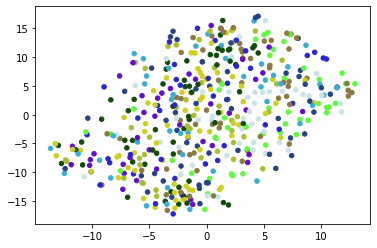

In [8]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [9]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245


ValueError: too many values to unpack (expected 2)

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [ ]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################


print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################


<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [ ]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]


#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################